<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Double Machine Learning: Use Cases and Examples

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

The EconML SDK implements the following DML classes:
* LinearDMLCateEstimator: suitable for estimating heterogeneous treatment effects.
* SparseLinearDMLCateEstimator: suitable for the case when $W$ is high dimensional vector and both the first stage and second stage estimate are linear.

In ths notebook, we show the performance of the DML on both synthetic data and observational data.

**Notebook contents:**

1. Example usage with single continuous treatment synthetic data
2. Example usage with single binary treatment synthetic data
3. Example usage with multiple continuous treatment synthetic data
4. Example usage with single continuous treatment observational data
5. Example usage with multiple continuous treatment, multiple outcome observational data

In [1]:
import econml

In [2]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Main imports
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator,SparseLinearDMLCateEstimator  

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV,LinearRegression,MultiTaskElasticNet,MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

## 1. Example Usage with Single Continuous Treatment Synthetic Data

### 1.1. DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [4]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [5]:
# DGP constants
np.random.seed(123)
n=1000
n_w=30
support_size=5
n_x=1
# Outcome support
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
epsilon_sample=lambda n: np.random.uniform(-1,1,size=n)
# Treatment support
support_T=support_Y
coefs_T=np.random.uniform(0,1,size=support_size)
eta_sample=lambda n: np.random.uniform(-1,1,size=n)

# Generate controls, covariates, treatments and outcomes
W=np.random.normal(0,1,size=(n,n_w))
X=np.random.uniform(0,1,size=(n,n_x))
# Heterogeneous treatment effects
TE=np.array([exp_te(x_i) for x_i in X])
T=np.dot(W[:,support_T],coefs_T)+eta_sample(n)
Y=TE*T+np.dot(W[:,support_Y],coefs_Y)+epsilon_sample(n)

# Generate test data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 1.2. Train Estimator
We train models in three different ways, and compare their performance.


#### 1.2.1. Default Setting

In [6]:
est = LinearDMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor(),random_state=123)
est.fit(Y, T, X, W)
te_pred = est.effect(X_test)

#### 1.2.2. Polynomial Features for Heterogeneity

In [7]:
est1 = LinearDMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor(),featurizer=PolynomialFeatures(degree=3),random_state=123)
est1.fit(Y, T, X, W)
te_pred1=est1.effect(X_test)

#### 1.2.3. Polynomial Features with regularization 

In [8]:
est2 = DMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor(),model_final=Lasso(alpha=0.1),featurizer=PolynomialFeatures(degree=10),random_state=123)
est2.fit(Y, T, X, W)
te_pred2=est2.effect(X_test)

### 1.3. Performance Visualization

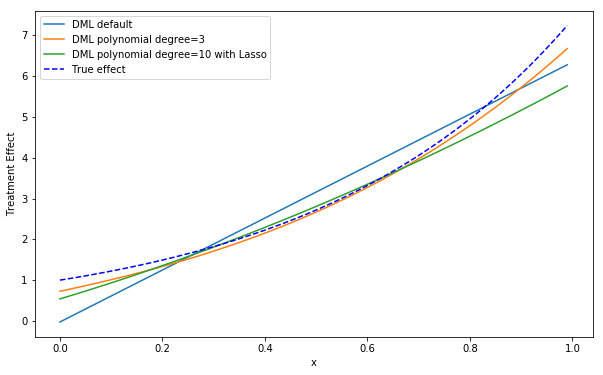

In [9]:
plt.figure(figsize=(10,6))
plt.plot(X_test,te_pred,label='DML default')
plt.plot(X_test,te_pred1,label='DML polynomial degree=3')
plt.plot(X_test,te_pred2,label='DML polynomial degree=10 with Lasso')
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test,expected_te,'b--',label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

### 1.4. Model selection

For the three different models above, we can use score function to estimate the final model performance. The score is the MSE of the final stage Y residual, which can be seen as a proxy of the MSE of treatment effect.

In [10]:
score={}
score["DML default"]=est.score(Y, T, X, W)
score["DML polynomial degree=2"]=est1.score(Y, T, X, W)
score["DML polynomial degree=10 with Lasso"]=est2.score(Y, T, X, W)
score

{'DML default': 2.3647631555429287,
 'DML polynomial degree=2': 2.2459648438125583,
 'DML polynomial degree=10 with Lasso': 2.640682077202371}

In [11]:
print("best model selected by score: ",min(score,key=lambda x: score.get(x)))

best model selected by score:  DML polynomial degree=2


In [12]:
mse_te={}
mse_te["DML default"]=((expected_te-te_pred)**2).mean()
mse_te["DML polynomial degree=2"]=((expected_te-te_pred1)**2).mean()
mse_te["DML polynomial degree=10 with Lasso"]=((expected_te-te_pred2)**2).mean()
mse_te

{'DML default': 0.20721788143063374,
 'DML polynomial degree=2': 0.0401206326900938,
 'DML polynomial degree=10 with Lasso': 0.20970254484181172}

In [13]:
print("best model selected by MSE of TE: ",min(mse_te,key=lambda x: mse_te.get(x)))

best model selected by MSE of TE:  DML polynomial degree=2


## 2. Example Usage with Single Binary Treatment Synthetic Data

### 2.1. DGP 
We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [14]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])# DGP constants
np.random.seed(1234)
n=1000
n_w=30
support_size=5
n_x=1
# Outcome support
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
epsilon_sample=lambda n:np.random.uniform(-1,1,size=n)
# Treatment support
support_T=support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# get testing data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 2.2. Train Estimator

In [15]:
est = LinearDMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestClassifier(),discrete_treatment=True)
est.fit(Y, T, X, W)
te_pred = est.effect(X_test)

### 2.3. Performance Visualization

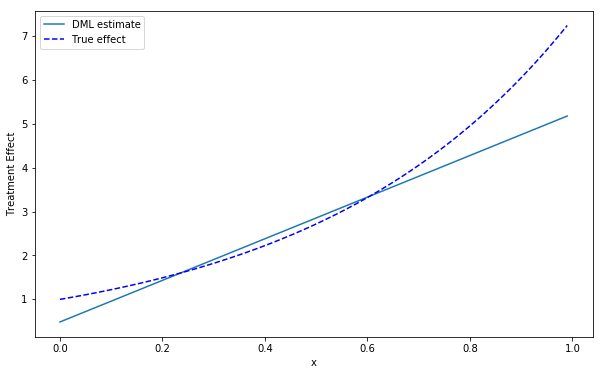

In [16]:
plt.figure(figsize=(10,6))
plt.plot(X_test,te_pred,label='DML estimate')
expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test,expected_te,'b--',label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

## 3. Example Usage with Multiple Continuous Treatment Synthetic Data

### 3.1. DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467), and modify the treatment to generate multiple treatments. The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta_{1}(X) + T^{2}\cdot \theta_{2}(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta_{1}(x) = \exp(2\cdot x_1)\\
\theta_{2}(x) = x_1^{2}\\
\end{align}

In [17]:
# DGP constants
np.random.seed(123)
n=1000
n_w=30
support_size=5
n_x=1
# Outcome support
support_Y=np.random.choice(range(n_w),size=support_size,replace=False)
coefs_Y=np.random.uniform(0,1,size=support_size)
epsilon_sample=lambda n: np.random.uniform(-1,1,size=n)
# Treatment support
support_T=support_Y
coefs_T=np.random.uniform(0,1,size=support_size)
eta_sample=lambda n: np.random.uniform(-1,1,size=n)

# Generate controls, covariates, treatments and outcomes
W=np.random.normal(0,1,size=(n,n_w))
X=np.random.uniform(0,1,size=(n,n_x))
# Heterogeneous treatment effects
TE1=np.array([exp_te(x_i) for x_i in X])
TE2=np.array([x_i**2 for x_i in X]).flatten()
T=np.dot(W[:,support_T],coefs_T)+eta_sample(n)
Y=TE1*T+TE2*T**2+np.dot(W[:,support_Y],coefs_Y)+epsilon_sample(n)
# Generate test data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

### 3.2. Train Estimator

In [18]:
est = LinearDMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor())

In [19]:
T=T.reshape(-1,1)
est.fit(Y, np.concatenate((T, T**2), axis=1), X, W)

In [20]:
te_pred=est.const_marginal_effect(X_test)

### 3.3. Performance Visualization

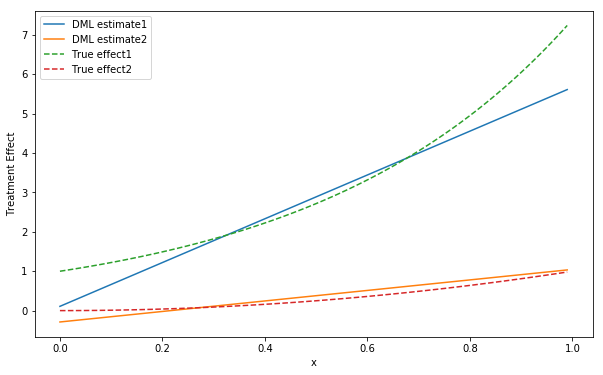

In [21]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred[:,0], label='DML estimate1')
plt.plot(X_test, te_pred[:,1], label='DML estimate2')
expected_te1 = np.array([exp_te(x_i) for x_i in X_test])
expected_te2=np.array([x_i**2 for x_i in X_test]).flatten()
plt.plot(X_test, expected_te1, '--', label='True effect1')
plt.plot(X_test, expected_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

## 4. Example Usage with Single Continuous Treatment Observational Data

We applied our technique to Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

The dataset is comprised of a large number of covariates $W$, but researchers might only be interested in learning the elasticity of demand as a function of a few variables $x$ such
as income or education. 

We applied the `LinearDMLCateEstimator` to estimate orange juice price elasticity
as a function of income, and our results, unveil the natural phenomenon that lower income consumers are more price-sensitive.

### 4.1. Data

In [22]:
# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [23]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)

In [24]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [25]:
# Prepare data
Y = oj_data['logmove'].values
T = np.log(oj_data["price"]).values
scaler = StandardScaler()
W1 = scaler.fit_transform(oj_data[[c for c in oj_data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
W2 = pd.get_dummies(oj_data[['brand']]).values
W = np.concatenate([W1, W2], axis=1)
X=scaler.fit_transform(oj_data[['INCOME']].values)

In [26]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

### 4.2. Train Estimator

In [27]:
est = LinearDMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor())
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

### 4.3. Performance Visualization

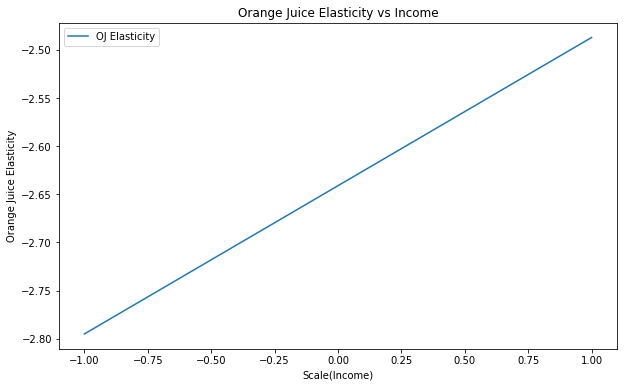

In [28]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### 4.4. Confidence Intervals

We can also get confidence intervals around our predictions by passing an additional `inference` argument to `fit`.  All estimators support bootstrap intervals, which involves refitting the same estimator repeatedly on subsamples of the original data, but `LinearDMLCateEstimator` also supports a more efficient approach which can be achieved by passing `'statsmodels'` as the inference argument.

In [29]:
est.fit(Y, T, X, W, inference='statsmodels')
te_pred=est.effect(X_test)
te_pred_interval = est.const_marginal_effect_interval(X_test, alpha=0.02)

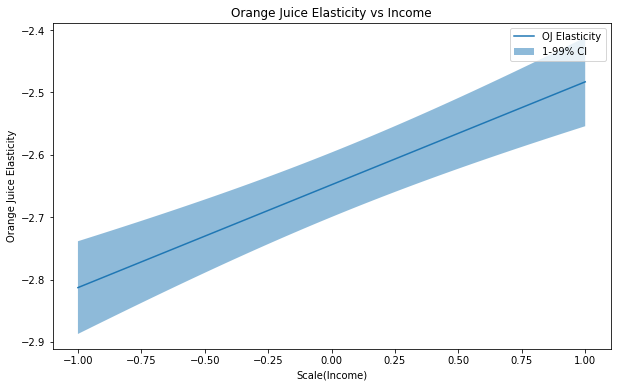

In [30]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## 5. Example Usage with Multiple Continuous Treatment, Multiple Outcome Observational Data

We use the same data, but in this case, we want to fit the demand of multiple brand as a function of the price of each one of them, i.e. fit the matrix of cross price elasticities. It can be done, by simply setting as $Y$ to be the vector of demands and $T$ to be the vector of prices. Then we can obtain the matrix of cross price elasticities.

\begin{align}
Y=[Logmove_{tropicana},Logmove_{minute.maid},Logmove_{dominicks}] \\
T=[Logprice_{tropicana},Logprice_{minute.maid},Logprice_{dominicks}] \\
\end{align}


### 5.1. Data

In [31]:
# Import the data
oj_data = pd.read_csv(file_name)

In [32]:
# Prepare data
oj_data['price']=np.log(oj_data["price"])
# Transform dataset. 
# For each store in each week, get a vector of logmove and a vector of logprice for each brand. 
# Other features are store specific, will be the same for all brands.
groupbylist=["store","week","AGE60","EDUC","ETHNIC","INCOME","HHLARGE","WORKWOM","HVAL150",
             "SSTRDIST","SSTRVOL","CPDIST5","CPWVOL5"]
oj_data1=pd.pivot_table(oj_data,index=groupbylist,columns=oj_data.groupby(groupbylist).cumcount(),
                        values=['logmove','price'],aggfunc='sum').reset_index()
oj_data1.columns=oj_data1.columns.map('{0[0]}{0[1]}'.format) 
oj_data1=oj_data1.rename(index=str,columns={"logmove0": "logmove_T", "logmove1": "logmove_M",
                                            "logmove2":"logmove_D","price0":"price_T","price1":"price_M","price2":"price_D"})

# Define Y,T,X,W
Y = oj_data1[['logmove_T',"logmove_M","logmove_D"]].values
T=oj_data1[['price_T',"price_M","price_D"]].values
scaler = StandardScaler()
W=scaler.fit_transform(oj_data1[[c for c in groupbylist if c not in ['week', 'store','INCOME']]].values)
X=scaler.fit_transform(oj_data1[['INCOME']].values)

In [33]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

### 5.2. Train Estimator

In [34]:
est = LinearDMLCateEstimator(model_y=MultiTaskElasticNetCV(cv=3, tol=1, selection='random'),
                             model_t=MultiTaskElasticNetCV(cv=3),
                             featurizer=PolynomialFeatures(1),
                             linear_first_stages=True)
est.fit(Y, T, X, W)
te_pred=est.const_marginal_effect(X_test)

### 5.3. Performance Visualization

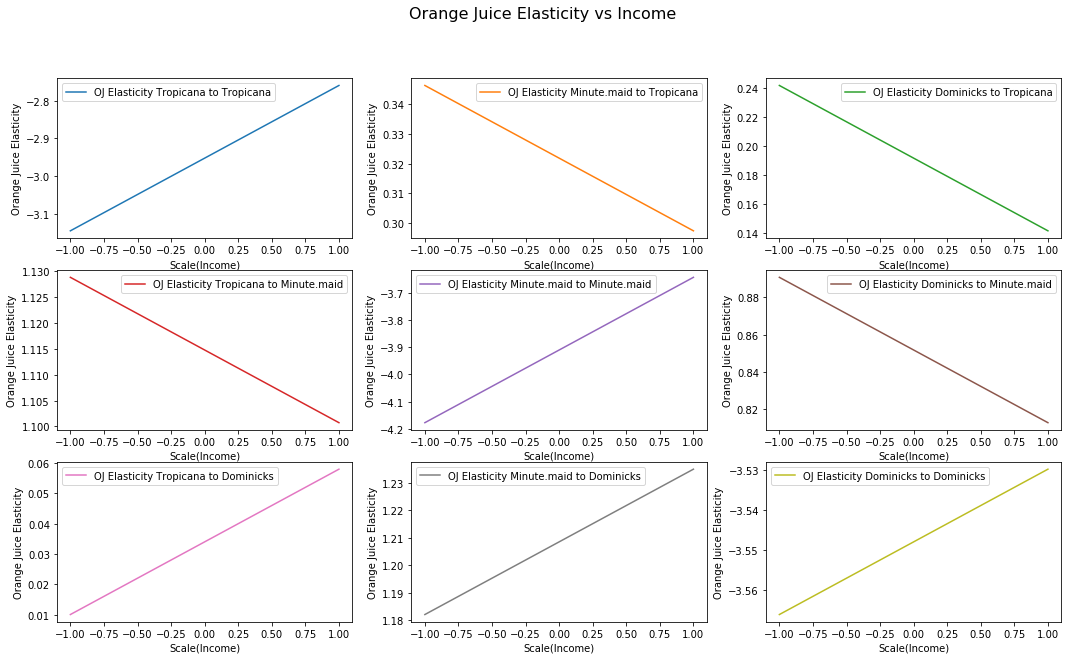

In [35]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18,10))
dic={0:"Tropicana",1:"Minute.maid",2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, 3*i+j+1)
        plt.plot(X_test, te_pred[:,i,j],color="C{}".format(str(3*i+j)),label="OJ Elasticity {} to {}".format(dic[j],dic[i]))
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()

**Findings**: Look at the diagonal of the matrix, the TE of OJ prices are always negative to the sales across all the brand, but people with higher income are less price-sensitive. By contrast, for the non-diagonal of the matrix, the TE of prices for other brands are always positive to the sales for that brand, the TE is affected by income in different ways for different competitors. In addition, compare to previous plot, the negative TE of OJ prices for each brand are all larger than the TE considering all brand together, which means we would have underestimated the effect of price changes on demand. 

### 5.4. Confidence Intervals

In [36]:
est.fit(Y,T,X,W, inference='statsmodels')
te_pred = est.const_marginal_effect(X_test)
te_pred_interval = est.const_marginal_effect_interval(X_test, alpha=0.02)

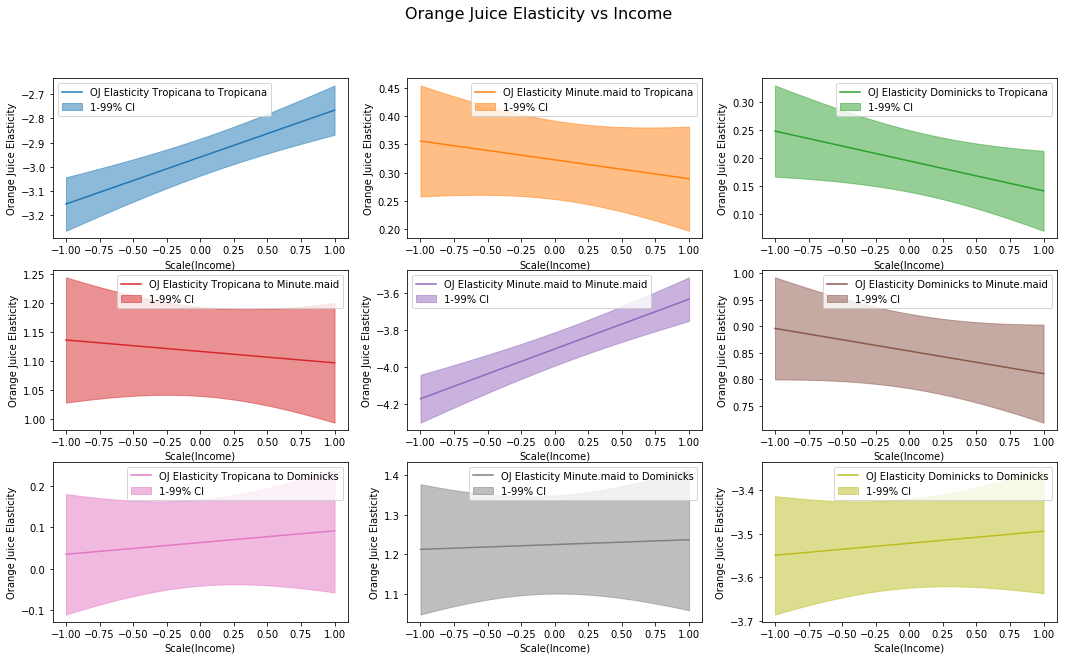

In [37]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18,10))
dic={0:"Tropicana",1:"Minute.maid",2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, 3*i+j+1)
        plt.plot(X_test, te_pred[:,i,j],color="C{}".format(str(3*i+j)),label="OJ Elasticity {} to {}".format(dic[j],dic[i]))
        plt.fill_between(X_test.flatten(), te_pred_interval[0][:, i, j],te_pred_interval[1][:, i,j], color="C{}".format(str(3*i+j)),alpha=.5, label="1-99% CI")
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()